# Import Library

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os 

# Import Dataset from Files
importing from files and resize to 256 x 256

Train Data

In [2]:
# function that would read an image provided the image path, preprocess and return it back
X_train = [] # To store train images
y_train = [] # To store train labels

# labels -
# 0 - Covid
# 1 - Normal

train_path = "./train/" # path containing training image samples
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0)
        elif folder.name[0]=='N':
            y_train.append(1)

In [3]:
X_train = np.array(X_train)
X_train.shape # We have 251 training samples in total

(181, 256, 256, 3)

In [4]:
y_train = np.array(y_train)
y_train.shape

(181,)

Test Data

In [5]:
#test image
X_test = []
y_test = []
test_path = "./test/"
for folder in os.scandir(test_path):
    for entry in os.scandir(test_path + folder.name):

        X_test.append(read_and_preprocess(test_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_test.append(0)
        elif folder.name[0]=='N':
            y_test.append(1)

In [6]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [7]:
X_test.shape

(46, 256, 256, 3)

In [8]:
y_test.shape

(46,)

# Exploratary Data Analysis
count and data visualization

covid= 111
normal= 70


<BarContainer object of 2 artists>

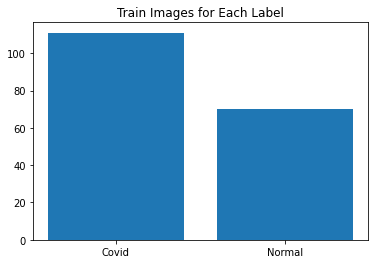

In [9]:
covid_count = len(y_train[y_train==0])
normal_count = len(y_train[y_train==1])
print('covid=' , covid_count)
print('normal=' , normal_count)
plt.title("Train Images for Each Label")
plt.bar(["Covid", "Normal"],[covid_count, normal_count])

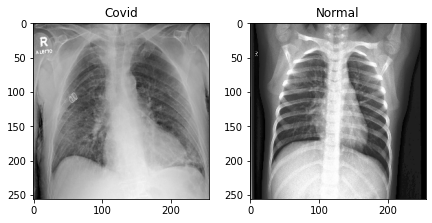

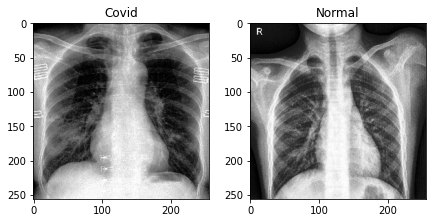

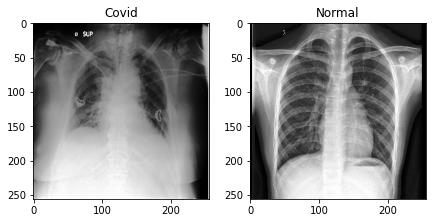

In [10]:
import random

title = {0:"Covid", 1:"Normal"}

rows = 3
columns = 3

for i in range(3):
    
    fig = plt.figure(figsize=(11,11))
    
    fig.add_subplot(rows, columns, 1)
    pos = random.randint(0, covid_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 2)
    pos = random.randint(covid_count, covid_count+normal_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    

# Image Preprocessing
process and extract image features

Gabor Function

In [11]:
import matplotlib.pyplot as plt # package for plot function

# show figures inline
%matplotlib inline 

def myimshow(I, **kwargs):
    # utility function to show image
    plt.figure();
    plt.axis('off')
    plt.imshow(I, cmap=plt.gray(), **kwargs)
    

def gabor(sz, sigma, theta, Lambda, psi, gamma):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))
   
    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb


Convolution Function

In [12]:
from typing import List, Tuple, Union
def add_padding(matrix: np.ndarray, 
                padding: Tuple[int, int]) -> np.ndarray:
    """Adds padding to the matrix. 
    Args:
        matrix (np.ndarray): Matrix that needs to be padded. Type is List[List[float]] casted to np.ndarray.
        padding (Tuple[int, int]): Tuple with number of rows and columns to be padded. With the `(r, c)` padding we addding `r` rows to the top and bottom and `c` columns to the left and to the right of the matrix
    Returns:
        np.ndarray: Padded matrix with shape `n + 2 * r, m + 2 * c`.
    """
    n, m = matrix.shape
    r, c = padding
    
    padded_matrix = np.zeros((n + r * 2, m + c * 2))
    padded_matrix[r : n + r, c : m + c] = matrix
    
    return padded_matrix

def _check_params(matrix, kernel, stride, dilation, padding):
    params_are_correct = (isinstance(stride[0], int)   and isinstance(stride[1], int)   and
                          isinstance(dilation[0], int) and isinstance(dilation[1], int) and
                          isinstance(padding[0], int)  and isinstance(padding[1], int)  and
                          stride[0]   >= 1 and stride[1]   >= 1 and 
                          dilation[0] >= 1 and dilation[1] >= 1 and
                          padding[0]  >= 0 and padding[1]  >= 0)
    assert params_are_correct, 'Parameters should be integers equal or greater than default values.'
    if not isinstance(matrix, np.ndarray):
        matrix = np.array(matrix)
    n, m = matrix.shape
    matrix = matrix if list(padding) == [0, 0] else add_padding(matrix, padding)
    n_p, m_p = matrix.shape

    if not isinstance(kernel, np.ndarray):
        kernel = np.array(kernel)
    k = kernel.shape
    
    kernel_is_correct = k[0] % 2 == 1 and k[1] % 2 == 1
    assert kernel_is_correct, 'Kernel shape should be odd.'
    matrix_to_kernel_is_correct = n_p >= k[0] and m_p >= k[1]
    assert matrix_to_kernel_is_correct, 'Kernel can\'t be bigger than matrix in terms of shape.'
    
    h_out = np.floor((n + 2 * padding[0] - k[0] - (k[0] - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - k[1] - (k[1] - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    out_dimensions_are_correct = h_out > 0 and w_out > 0
    assert out_dimensions_are_correct, 'Can\'t apply input parameters, one of resulting output dimension is non-positive.'

    return matrix, kernel, k, h_out, w_out

def conv2d(matrix: Union[List[List[float]], np.ndarray], 
             kernel: Union[List[List[float]], np.ndarray], 
             stride: Tuple[int, int] = (1, 1), 
             dilation: Tuple[int, int] = (1, 1), 
             padding: Tuple[int, int] = (0, 0)) -> np.ndarray:
    """Makes a 2D convolution with the kernel over matrix using defined stride, dilation and padding along axes.
    Args:
        matrix (Union[List[List[float]], np.ndarray]): 2D matrix to be convolved.
        kernel (Union[List[List[float]], np.ndarray]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
        stride (Tuple[int, int], optional): Tuple of the stride along axes. With the `(r, c)` stride we move on `r` pixels along rows and on `c` pixels along columns on each iteration. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Tuple of the dilation along axes. With the `(r, c)` dilation we distancing adjacent pixels in kernel by `r` along rows and `c` along columns. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Tuple with number of rows and columns to be padded. Defaults to (0, 0).
    Returns:
        np.ndarray: 2D Feature map, i.e. matrix after convolution.
    """
    matrix, kernel, k, h_out, w_out = _check_params(matrix, kernel, stride, dilation, padding)
    matrix_out = np.zeros((h_out, w_out))
    
    b = k[0] // 2, k[1] // 2
    center_x_0 = b[0] * dilation[0]
    center_y_0 = b[1] * dilation[1]
    for i in range(h_out):
        center_x = center_x_0 + i * stride[0]
        indices_x = [center_x + l * dilation[0] for l in range(-b[0], b[0] + 1)]
        for j in range(w_out):
            center_y = center_y_0 + j * stride[1]
            indices_y = [center_y + l * dilation[1] for l in range(-b[1], b[1] + 1)]

            submatrix = matrix[indices_x, :][:, indices_y]

            matrix_out[i][j] = np.sum(np.multiply(submatrix, kernel))
    return matrix_out

def apply_filter_to_image(image: np.ndarray, 
                          kernel: List[List[float]]) -> np.ndarray:
    """Applies filter to the given image.
    Args:
        image (np.ndarray): 3D matrix to be convolved. Shape must be in HWC format.
        kernel (List[List[float]]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
    Returns:
        np.ndarray: image after applying kernel.
    """
    kernel = np.asarray(kernel)
    b = kernel.shape
    return np.dstack([conv2d(image[:, :, z], kernel, padding=(b[0]//2,  b[1]//2)) 
                      for z in range(3)]).astype('uint8')




 

Feature Extractor
(Extract color features, make gabor kernel, convolve to image)

In [13]:
def feature_extractor(data):
    x_train = data
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):
        df = pd.DataFrame()
        input_img = x_train[image, :,:,:]
        img = input_img
        
        #feature 1 - pixel values
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
        
        #feature 2 - gabor features
        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        parameters  = []
        img_list = []
        for theta in range(2):   #Define number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  #Sigma with 1 and 3
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
    #                print(gabor_label)
                ksize=9
                kernel = gabor((ksize,ksize),sigma,theta,lamda,0,gamma)
#                 kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)  
                #                 myimshow(kernel)
                
                kernels.append(kernel)
                p = [sigma, theta, lamda, gamma]
                parameters.append(p)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                img_list.append(fimg)
#                 fimg = apply_filter_to_image(img, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                #print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
        
        image_dataset = image_dataset.append(df)
    
    return image_dataset,parameters,kernels

#extract train data
image_feat, param,kernel= feature_extractor(X_train)

# Feature results

In [14]:
# Get all kernel value
import pylab as pl
kernels = []
for i in param:
    kernel = gabor((9,9),i[0], i[1], i[2],0, i[3])
    kernels.append(kernel)

In [16]:
param


[[1, 0.0, 0.7853981633974483, 0.5],
 [3, 0.0, 0.7853981633974483, 0.5],
 [1, 0.7853981633974483, 0.7853981633974483, 0.5],
 [3, 0.7853981633974483, 0.7853981633974483, 0.5]]

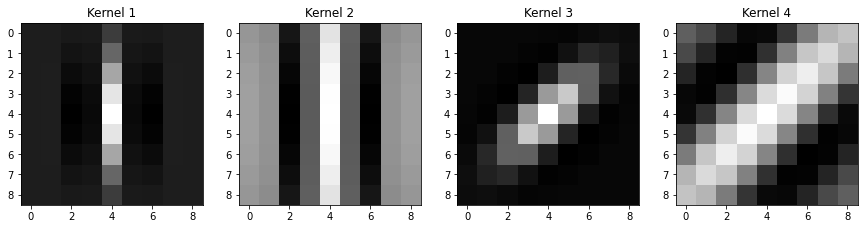

In [15]:
fig, ax = plt.subplots(1,4, figsize = (15,15))
for i in range(0,4):
    ax[i].imshow(kernels[i],cmap='gray')
    ax[i].set_title('Kernel ' + str(i+1))

Text(0.5, 0.98, 'Covid')

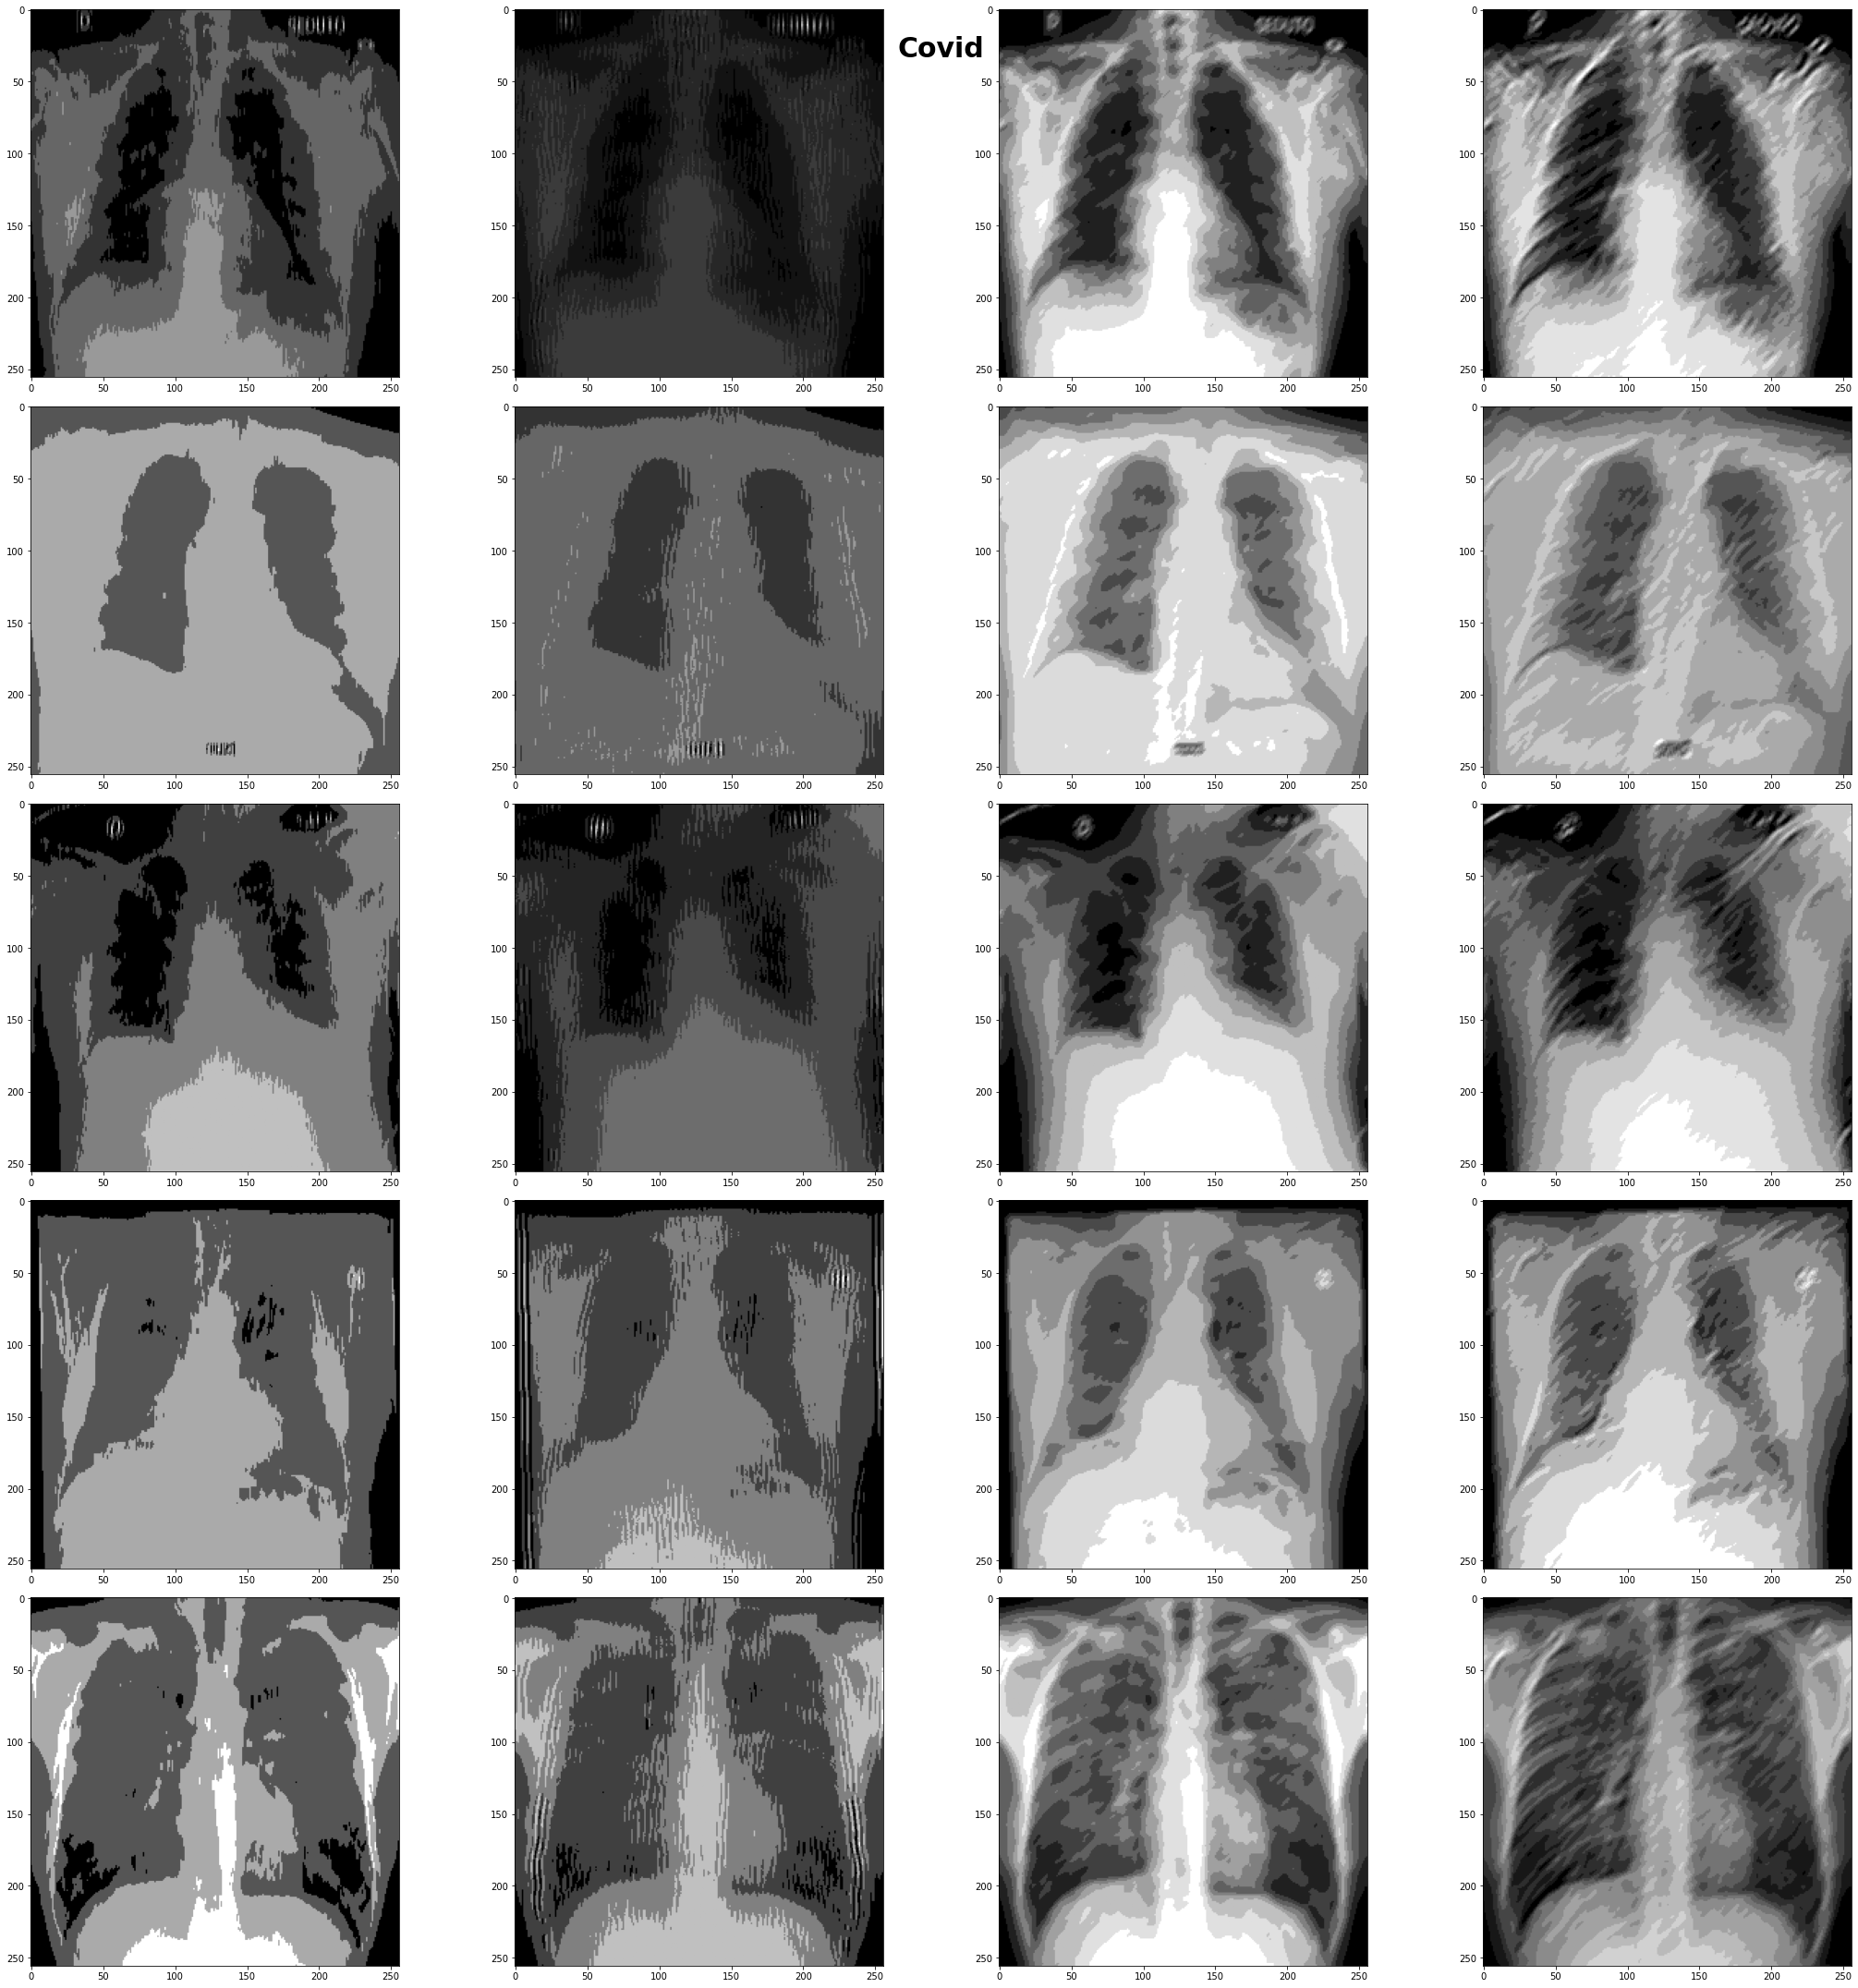

In [16]:
#Visualization
image = []
for i in range(0,6):   
    img = X_train[i]
# plt.imshow(img, cmap='gray')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for j in kernels :
        fimg = cv2.filter2D(img,cv2.CV_8UC3, j)
        image.append(fimg)
        
   

fig, ax = plt.subplots(5,4, figsize = (30,30))

temp = 0
for i in range (0,5):
    for j in range (0,4):
        ax[i,j].imshow(image[temp],cmap="gray")
#         if temp > 3 :
#             ax[i,j].set_title('Covid', fontsize = 12)
#         else :
#             ax[i,j].set_title('Normal', fontsize = 12)
        temp += 1

fig.tight_layout()
fig.suptitle('Covid', fontsize = 30,fontweight='bold') 

Text(0.5, 0.98, 'Normal')

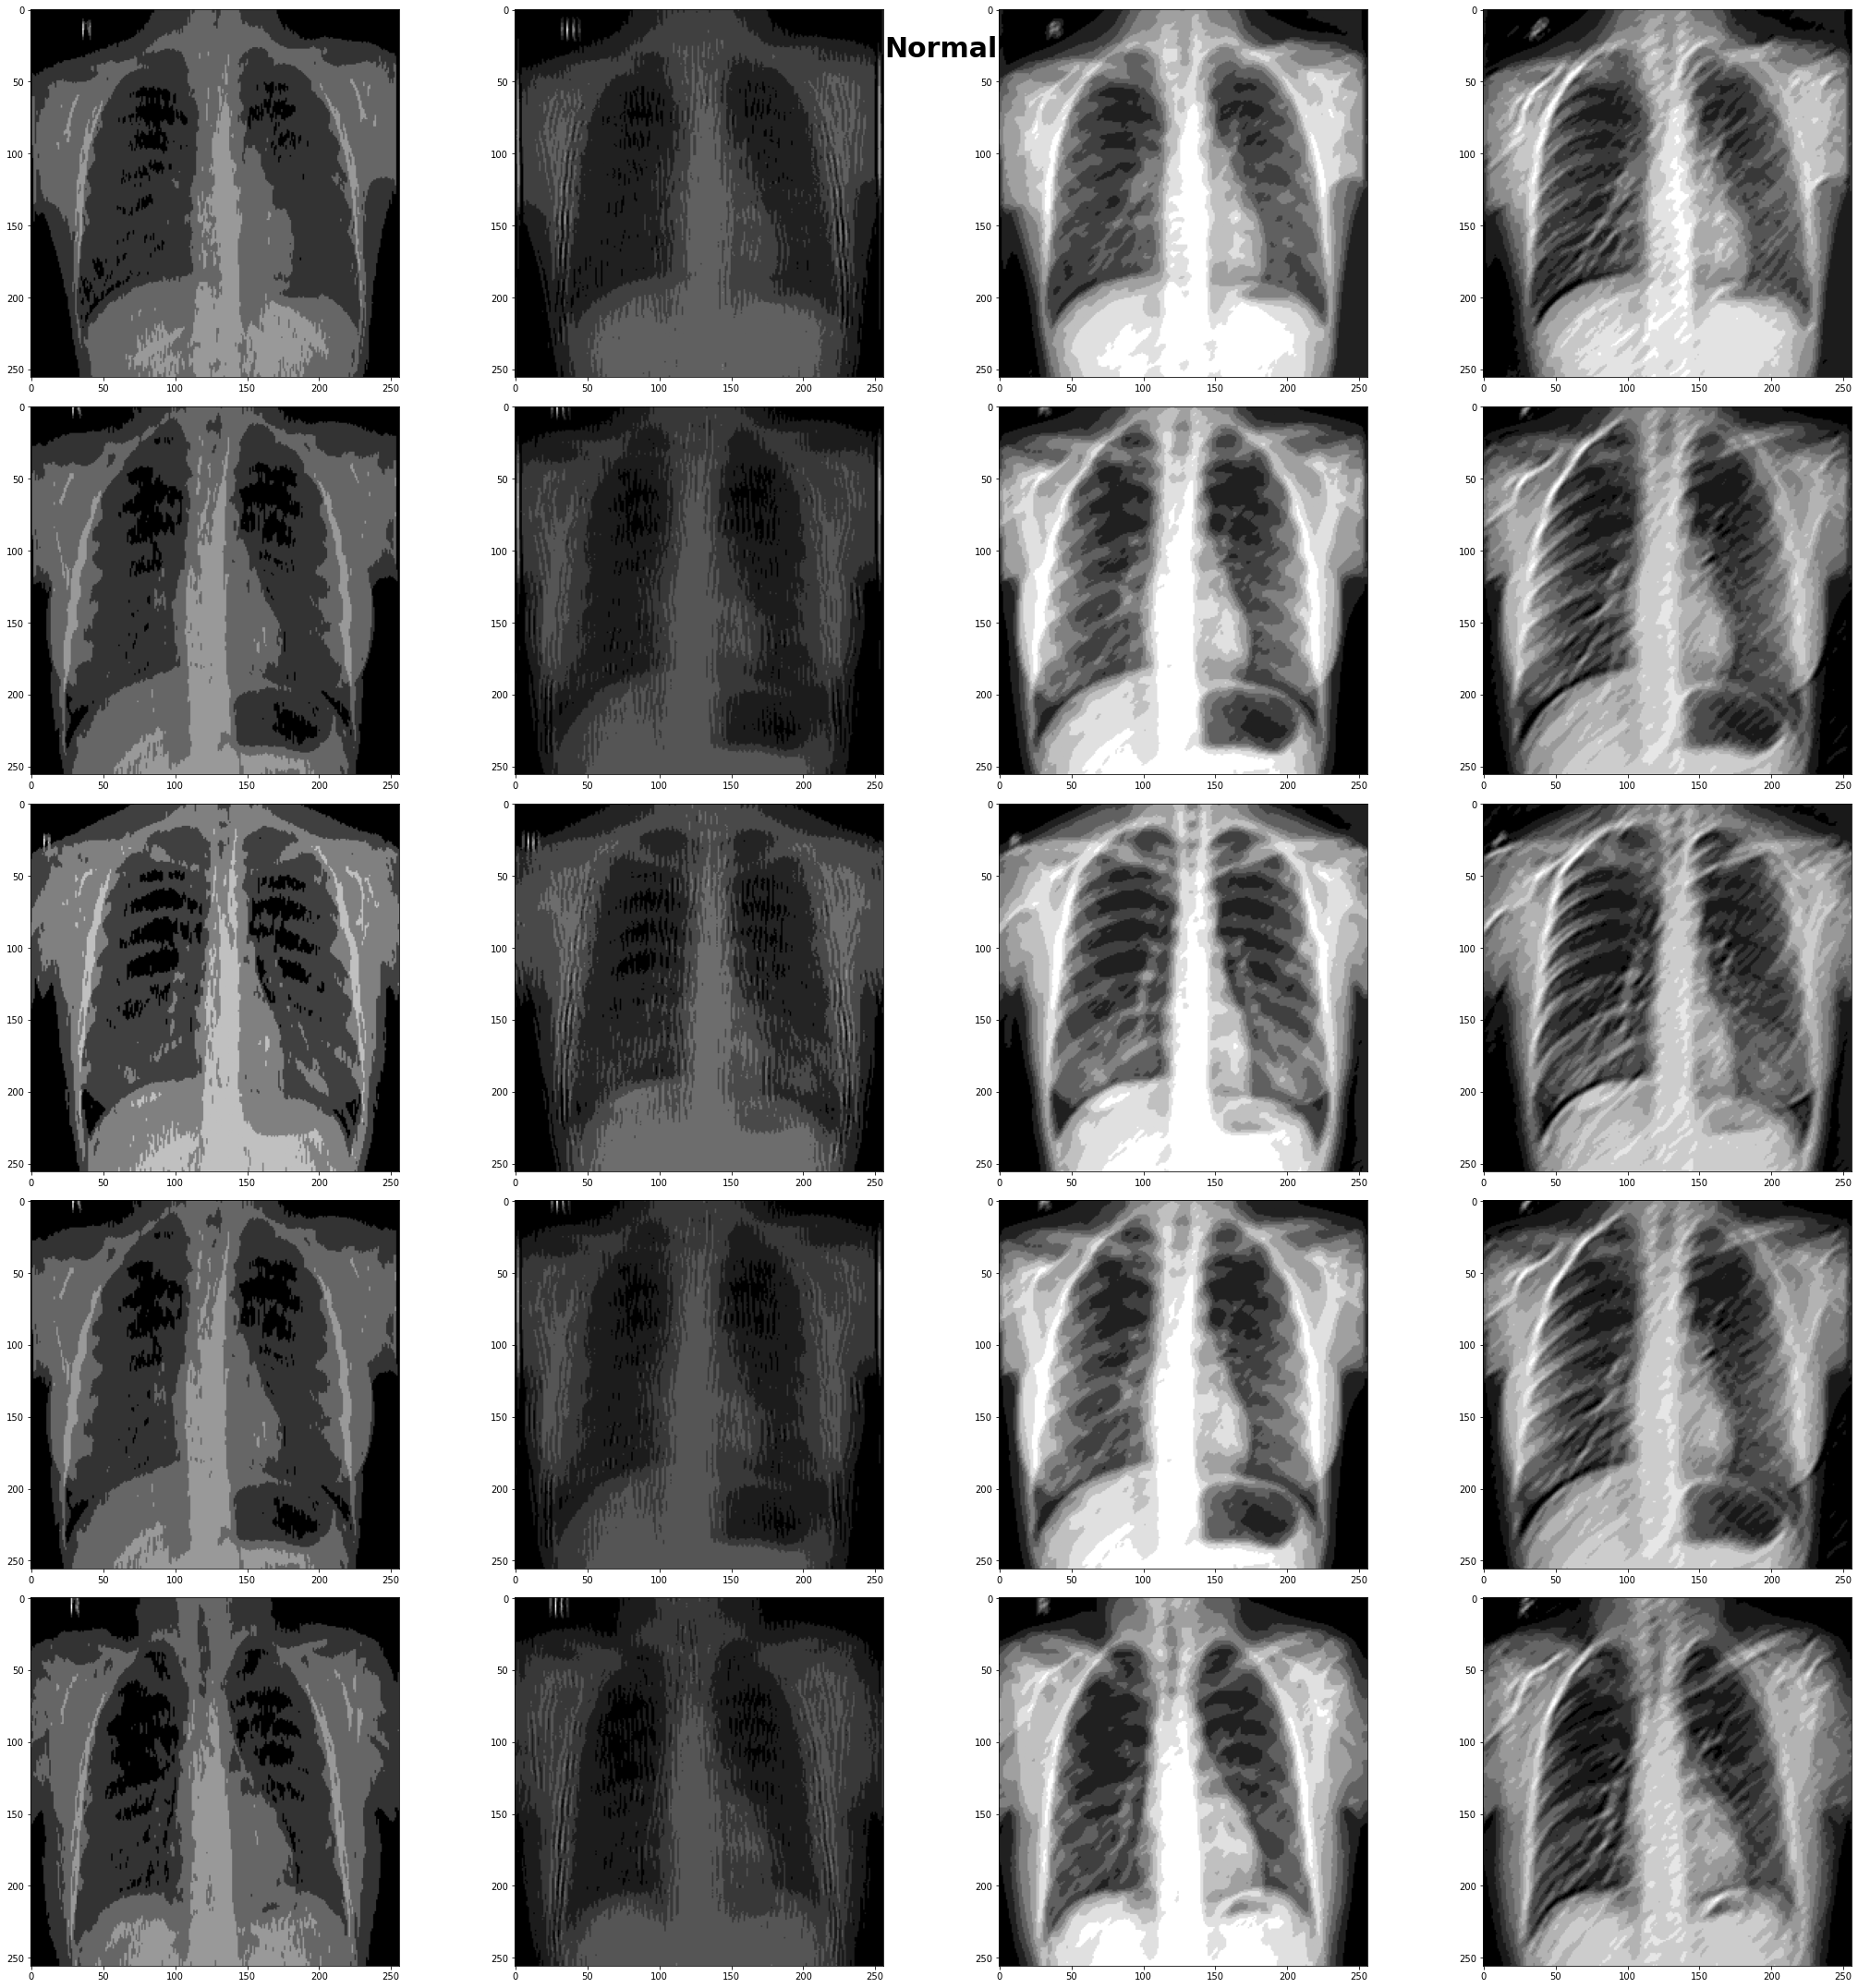

In [17]:
image = []
for i in range(120,126):   
    img = X_train[i]
# plt.imshow(img, cmap='gray')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for j in kernels :
        fimg = cv2.filter2D(img,cv2.CV_8UC3, j)
        image.append(fimg)
        
   

fig, ax = plt.subplots(5,4, figsize = (30,30))

temp = 0
for i in range (0,5):
    for j in range (0,4):
        ax[i,j].imshow(image[temp],cmap='gray')
#         if temp > 3 :
#             ax[i,j].set_title('Covid', fontsize = 12)
#         else :
#             ax[i,j].set_title('Normal', fontsize = 12)
        temp += 1

fig.tight_layout()
fig.suptitle('Normal', fontsize = 30,fontweight='bold') 

# Modeling
input train data to model and testing model with test data

In [18]:
n_features = image_feat.shape[1]
image_feat = np.expand_dims(image_feat, axis=0)
X_for_RF = np.reshape(image_feat, (X_train.shape[0], -1))

In [19]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
RF_model.fit(X_for_RF, y_train) 

RandomForestClassifier(n_estimators=50, random_state=42)

In [20]:
test_features,param,kernel = feature_extractor(X_test)

test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (X_test.shape[0], -1))

test_prediction = RF_model.predict(test_for_RF)
#Inverse le transform to get original label back. 


Performance

In [21]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, test_prediction))

#Print confusion matrix
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test, test_prediction)

Accuracy =  0.9782608695652174


In [22]:
print(cm)

[[25  1]
 [ 0 20]]


In [23]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.95      1.00      0.98        20

    accuracy                           0.98        46
   macro avg       0.98      0.98      0.98        46
weighted avg       0.98      0.98      0.98        46



In [24]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, test_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_prediction)))

Mean Absolute Error: 0.021739130434782608
Mean Squared Error: 0.021739130434782608
Root Mean Squared Error: 0.14744195615489714


In [25]:
import joblib
joblib.dump(RF_model, "./covidlungs_model")

['./covidlungs_model']